In [9]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset, concatenate_datasets
import json
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import math


In [10]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class Encoder(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

        # better init, not covered in the original GPT video, but important, will cover in followup video
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.001)

    def forward(self, idx, targets=None, mask = None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)
        probs = F.softmax(logits, dim = 2)

        if targets is None:
            loss = None
        else:
            # eps = 1e-9
            # loss = -torch.sum((targets*torch.log(y+eps)+(1-targets)*torch.log(1-y+eps)).mean(dim=0))
            # logits = logits[:,,:]
            T2 = targets.shape[1]
            loss = 0
            for i in range(T2):
                v1 = logits[torch.arange(B),mask[:,i],:]
                # print(v1.shape)
                # print(targets[:,i].shape)
                # print(F.cross_entropy(v1, targets[:,i]))
                loss += F.cross_entropy(v1, targets[:,i])
            loss /= T2
            # # logits = logits.view(B*T, vocab_size)
            # targets = targets.view(B*T)
            # loss = F.cross_entropy(logits, targets)
        return probs, loss


In [11]:
# hyperparameters
batch_size = 1000 # how many independent sequences will we process in parallel?
block_size = 100 # what is the maximum context length for predictions?
max_iters = 5000
device = 'cuda' if torch.cuda.is_available() else 'cpu'
n_embd = 64 #384
n_head = 4
n_layer = 4
dropout = 0.2
vocab_size = 4
# ------------

d = 5 # must be an odd number
model = Encoder()
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

num_mask = 4
p_err_train = 0.1
p_err_val = 0.15
dataset = load_dataset("json", data_files={
        'train' : f"datasets/train_enc_mask_{num_mask}_d_{d}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_enc_mask_{num_mask}_d_{d}_p_{p_err_val:.2f}.json"
    })

def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    mask = [example['mask'] for example in examples]
    return {'input': input, 'target': target, 'mask': mask}

data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset["val"], batch_size=batch_size, collate_fn=collate_fn)


206212 parameters


Generating train split: 1000000 examples [00:01, 543130.91 examples/s]
Generating val split: 1000 examples [00:00, 154662.93 examples/s]


In [4]:
ind = 4
print(len(dataset["train"]['input'][ind]))
print(dataset["train"]['errors'][ind])
examples = dataset["train"][:2]


36
{'x': [], 'z': [], 'y': [12]}


In [10]:
ind = 10
x = torch.tensor(dataset["train"]["input"][:ind]).to(device, dtype= torch.int32)
Y = torch.tensor(dataset["train"]["target"][:ind]).to(device, dtype= torch.long)
mask = torch.tensor(dataset["train"]["mask"][:ind]).to(device, dtype= torch.int32)
# model(x, Y, mask)

Y = torch.tensor(dataset["train"]["target"][:ind]).to(device, dtype= torch.int32)
logits, _ = model(x)

B = Y.shape[0]
T2 = Y.shape[1]
acc = 0
for i2 in range(T2):
    v1 = logits[torch.arange(B),mask[:,i2],:]
    probs = F.softmax(v1, dim = 1)
    id_max = torch.argmax(probs, dim = 1)

# probs = F.softmax(logits, dim = 1)
    # print(id_max.shape)
# pred = (err_probs[:,i] > 0.5)
    acc += torch.sum(id_max == Y[:,i2])/B

acc/= T2
print(acc)

tensor(0.3250, device='cuda:0')


In [13]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    losses = torch.zeros(eval_iters)
    i = 0
    # data_loader_loss = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader:
        if i >= eval_iters:
            break
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch["target"]).to(device, dtype= torch.long)
        mask = torch.tensor(batch["mask"]).to(device, dtype= torch.int32)

        _, loss = model(X,Y, mask)

        losses[i] = loss.item()
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch["target"]).to(device, dtype= torch.long)
        mask = torch.tensor(batch["mask"]).to(device, dtype= torch.int32)

        _, loss = model(X,Y, mask)

        out["val"] += loss.item()
        i += 1
    out["val"] /= i
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        # X = torch.tensor(batch['input']).to(device)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch["target"]).to(device, dtype= torch.long)
        mask = torch.tensor(batch["mask"]).to(device, dtype= torch.int32)
        logits, _ = model(X)
        B = Y.shape[0]
        T2 = Y.shape[1]
        for i2 in range(T2):
            v1 = logits[torch.arange(B),mask[:,i2],:]
            probs = F.softmax(v1, dim = 1)
            id_max = torch.argmax(probs, dim = 1)
            acc += torch.sum(id_max == Y[:,i2])/B

        acc/= T2
        i += 1
    acc /= i
    
    model.train()
    return acc.item()


In [18]:
learning_rate = 3e-3
# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

eval_interval = 100
eval_iters =  10
num_epochs = 10000

loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    # if epoch % 10 == 0:
    # # if iter % eval_interval == 0:
    #     losses = estimate_loss()
    #     acc = estimate_accuracy()
    #     print(f"epoch {epoch}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
    #     loss_train.append(losses['train'])
    #     loss_val.append(losses['val'])
    #     acc_val.append(acc)

    # data_loader = DataLoader(dataset["train"], batch_size=batch_size, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # if i_b>= eval_iters:
        #     break
        # # every once in a while evaluate the loss on train and val sets
        # if epoch % 10 == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            acc = estimate_accuracy()
            print(f"epoch, step {epoch, iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            acc_val.append(acc)
        X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
        Y = torch.tensor(batch["target"]).to(device, dtype= torch.long)
        mask = torch.tensor(batch["mask"]).to(device, dtype= torch.int32)
        _, loss = model(X,Y, mask)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        iter += 1



epoch, step (0, 0): train loss 0.4375, val loss 0.5410, val acc 0.7453
epoch, step (0, 100): train loss 0.4227, val loss 0.5320, val acc 0.7490
epoch, step (0, 200): train loss 0.4137, val loss 0.5239, val acc 0.7452
epoch, step (0, 300): train loss 0.4105, val loss 0.5294, val acc 0.7460
epoch, step (0, 400): train loss 0.4073, val loss 0.5257, val acc 0.7440
epoch, step (0, 500): train loss 0.4054, val loss 0.5300, val acc 0.7490
epoch, step (0, 600): train loss 0.4057, val loss 0.5205, val acc 0.7558


In [1]:

plt.plot(loss_train,".-",label="Train loss")
plt.plot(loss_val,".-",label="Val loss")
plt.plot(acc_val,".-",label="accuracy")
plt.legend()


NameError: name 'plt' is not defined

In [15]:
model.eval()
acc = 0
i = 0
for batch in data_loader_val:
    # if i >= eval_iters:
    #     break
    X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
    Y = torch.tensor(batch["target"]).to(device, dtype= torch.long)
    mask = torch.tensor(batch["mask"]).to(device, dtype= torch.int32)
    with torch.no_grad():
        logits, _ = model(X)
    B = Y.shape[0]
    T2 = Y.shape[1]
    for i2 in range(T2):
        v1 = logits[torch.arange(B),mask[:,i2],:]
        probs = F.softmax(v1, dim = 1)
        id_max = torch.argmax(probs, dim = 1)
        print(id_max)
        acc += torch.sum(id_max == Y[:,i2])/B

    acc/= T2
    i += 1
acc /= i

model.train()
print(acc.item())

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [62]:
PATH = f"models/enc_hl_{n_head}_{n_layer}_lr_{learning_rate:.4f}_dtrained_{d}.pt"
# saving the state
# model.to(device)
# torch.save(model.state_dict(), PATH)
checkpoint = {
"epoch": 2,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
torch.save(checkpoint, PATH)

In [ ]:
d = 5 # must be an odd number
n_hidden = 512
learning_rate = 1
FILE = f"models/enc_hl_{n_head}_{n_layer}_lr_{learning_rate:.3f}.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = Encoder()

optimizer = torch.optim.AdamW(model.parameters(), lr=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

In [13]:
# d = 5 # must be an odd number
# n_hidden = [500, 512, 512]
# learning_rate = [1e-2,1e-2,1e-3]
# device = "cuda" if torch.cuda.is_available() else "cpu"

batch_size = 1000
p_err_list = torch.arange(0.01,0.31,0.01)
d_list = [5,7,9]
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):
    # model = load_model(d,n_hidden[i_d],learning_rate)
    # FILE = f"models/d_{d}_nh_{n_hidden[i_d]}_lr_{learning_rate[i_d]:.3f}.pt"

    # model = MLP(d, n_hidden[i_d])

    # optimizer = torch.optim.AdamW(model.parameters(), lr=0)
    # checkpoint = torch.load(FILE)
    # model.load_state_dict(checkpoint['model_state'])
    # optimizer.load_state_dict(checkpoint['optim_state'])
    # epoch = checkpoint['epoch']

    # # model.load_state_dict(torch.load(PATH))
    # model.to(device)
    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                'test' : f"datasets/test_enc_d_{d}_p_{p_err:.2f}.json"
            })
        data_loader_test = DataLoader(dataset["test"], batch_size=batch_size, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device, dtype= torch.int32)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

# model.train()
# del model


Generating test split: 1000 examples [00:00, 153032.11 examples/s]
Generating test split: 1000 examples [00:00, 161642.67 examples/s]
Generating test split: 1000 examples [00:00, 166871.06 examples/s]
Generating test split: 1000 examples [00:00, 162167.65 examples/s]
Generating test split: 1000 examples [00:00, 176194.24 examples/s]
Generating test split: 1000 examples [00:00, 164598.70 examples/s]
Generating test split: 1000 examples [00:00, 161592.85 examples/s]
Generating test split: 1000 examples [00:00, 165586.42 examples/s]
Generating test split: 1000 examples [00:00, 175788.10 examples/s]
Generating test split: 1000 examples [00:00, 160412.44 examples/s]
Generating test split: 1000 examples [00:00, 157508.88 examples/s]
Generating test split: 1000 examples [00:00, 159728.25 examples/s]
Generating test split: 1000 examples [00:00, 163380.49 examples/s]
Generating test split: 1000 examples [00:00, 162268.03 examples/s]
Generating test split: 1000 examples [00:00, 162167.65 example

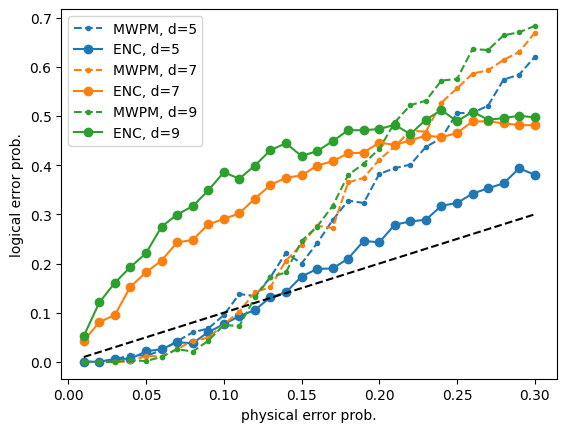

In [14]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for i_d, d in enumerate(d_list):
    p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    plt.plot(p_err_list,logical_err_mwpm,".--", color= f"C{i_d}",label=f"MWPM, d={d}")
    plt.plot(p_err_list,1-acc[:,i_d],"o-", color= f"C{i_d}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()


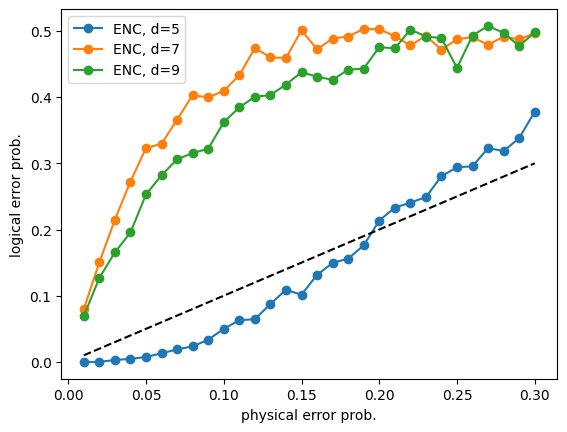

In [53]:
for i_d, d in enumerate(d_list):
    plt.plot(p_err_list,1-acc[:,i_d],"o-", color= f"C{i_d}",label=f"ENC, d={d}")

plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
